# CNN Exercise 2: Image Classification with CNNs

We will use the CIFAR10 dataset, which consists of 60000 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. In this exercise we will only use the dog and cat classes and we will train a CNN to distinguish between the two.

In the following cell we load the dataset again from ```torchvision.datasets```. There is a bunch of code that is not relevant for this exercise, but you can have a look at it if you are interested. The important part is that we load training and test data, only select the dog and cat classes, and do some augmentation and normalizing of the data.

Thanks to [this Gist](https://gist.github.com/Miladiouss/6ba0876f0e2b65d0178be7274f61ad2f) for the code to load the CIFAR10 dataset.

Created by Cedric Ewen in 2023


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# transformations
RC = transforms.RandomCrop(32, padding=4)
RHF = transforms.RandomHorizontalFlip()
NRM = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
TT = transforms.ToTensor()

# transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TT, RC, RHF, NRM])
# transforms object for testset w/o augmentation
transform_no_aug = transforms.Compose([TT, NRM])

# downloading/louding CIFAR10 data
trainset = CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transform_with_aug)
testset = CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=transform_no_aug)
classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
           'horse', 'ship', 'truck']

# separating trainset/testset data/label
x_train = trainset.data
x_test = testset.data
y_train = np.array(trainset.targets)
y_test = np.array(testset.targets)

100%|██████████| 170M/170M [00:02<00:00, 72.2MB/s]


We now choose the classes we want to use for the classification. We start with cats and dogs and will later add more classes.

In [5]:
# This code block will remove all data samples that do not belong to
# class 'cat' or to class 'dog'.
classes = ['cat', 'dog']

# all classes of CIFAR-10
#classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# initialize masks and map according to chosen classes
mask_train = np.zeros(len(y_train), dtype=bool)
mask_test = np.zeros(len(y_test), dtype=bool)
lable_map = {}
for i, class_name in enumerate(classes):
    mask_train = mask_train | (y_train == classDict[class_name])
    mask_test = mask_test | (y_test == classDict[class_name])
    lable_map[classDict[class_name]] = i

# select data
trainset.data = x_train[mask_train]
testset.data = x_test[mask_test]
trainset.targets = y_train[mask_train].tolist()
testset.targets = y_test[mask_test].tolist()

# make class labels continuous again
trainset.targets = [lable_map[e] for e in trainset.targets]
testset.targets = [lable_map[e] for e in testset.targets]

In [6]:
batch_size = 64

# create dataset loaders from trainset and testset
kwargs = {'num_workers': 4, 'pin_memory': False,
          'batch_size': batch_size}
trainloader = DataLoader(
    trainset, shuffle=True, **kwargs)
testloader = DataLoader(
    testset, shuffle=False, **kwargs)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


We now have a training and test set of the selected classes that are one-hot-encoded. Let's look at some of the images.
- What's the size of the images?
- How many images do we have in training and test set?

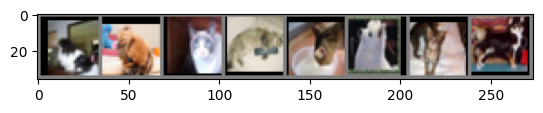

dog   dog   cat   cat   cat   dog   cat   dog  


In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)

images, labels = next(dataiter)

images_to_plot = 8

# show images
imshow(torchvision.utils.make_grid(images[:images_to_plot]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(images_to_plot)))

In [9]:
# TODO: print image shape and dataset length
print(images.shape)
print(len(trainset))

torch.Size([64, 3, 32, 32])
10000


# Define the Network
This is the only area you will need to change.  Look at the picture of LeNet here.

In [91]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # # Alex start
        # self.conv1 = nn.Conv2d(in_channels=3   , out_channels= 18, kernel_size= 5, stride=1, padding=2) # -> 32x32

        # self.conv2 = nn.Conv2d(in_channels=18  , out_channels= 48, kernel_size= 5, stride=1, padding=2)
        # self.conv3a = nn.Conv2d(in_channels=48, out_channels= 48, kernel_size= 3, stride=1, padding=2)
        # self.conv3b = nn.Conv2d(in_channels=48, out_channels=48, kernel_size= 3, stride=1, padding=2)
        # self.conv3c = nn.Conv2d(in_channels=48, out_channels=48, kernel_size= 3, stride=1, padding=2)

        # self.pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)                              # 32x32 -> 16x16
        # self.dropout = nn.Dropout(p=0.5)

        # self.fully_connected1 = nn.Linear(in_features=6*6*48, out_features=4096)
        # self.fully_connected2 = nn.Linear(in_features=4096, out_features=1000)
        # self.fully_connected3 = nn.Linear(in_features=1000,out_features=2)
        # # We also use only 2 classes (cats and dogs) now instead of 10.

        self.conv1 = nn.Conv2d(in_channels=3 , out_channels=24,  kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.pooling1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.pooling2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.fully_connected1 = nn.Linear(in_features=6*6*16, out_features=180)
        self.fully_connected2 = nn.Linear(in_features=180, out_features=84)
        self.fully_connected3 = nn.Linear(in_features=84,out_features=2)

    def forward(self, x):
          # Pass data through conv1
        x = self.conv1(x)
        x = F.sigmoid(x)
        x = self.pooling1(x)

        x = self.conv2(x)
        x = F.sigmoid(x)
        x = self.pooling2(x)

        x = torch.flatten(x, 1)
        x = self.fully_connected1(x)

        x = torch.sigmoid(x)
        x = self.fully_connected2(x)
        x = torch.sigmoid(x)

        x = self.fully_connected3(x)

        output=x
        return output


    # def forward(self, x):
        #TODO: run layer
        # x = self.conv1(x)
        # x = F.relu(x)
        # x = self.pooling(x)

        # x = self.conv2(x)
        # x = F.relu(x)
        # x = self.pooling(x)

        # x = self.conv3a(x)
        # x = F.relu(x)
        # x = self.conv3b(x)
        # x = F.relu(x)
        # x = self.conv3c(x)
        # x = F.relu(x)
        # x = torch.flatten(x, 1)

        # x = self.dropout(x)

        # x = self.fully_connected1(x)
        # x = F.relu(x)
        # x = self.dropout(x)

        # x = self.fully_connected2(x)
        # x = F.relu(x)
        # x = self.dropout(x)

        # x = self.fully_connected3(x)

        # output = x
        # return output

In [92]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(24, 16, kernel_size=(5, 5), stride=(1, 1))
  (pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (pooling2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fully_connected1): Linear(in_features=576, out_features=180, bias=True)
  (fully_connected2): Linear(in_features=180, out_features=84, bias=True)
  (fully_connected3): Linear(in_features=84, out_features=2, bias=True)
)


In [93]:
summary(model, (3, 32, 32), batch_size=batch_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 24, 32, 32]           1,824
         AvgPool2d-2           [64, 24, 16, 16]               0
            Conv2d-3           [64, 16, 12, 12]           9,616
         AvgPool2d-4             [64, 16, 6, 6]               0
            Linear-5                  [64, 180]         103,860
            Linear-6                   [64, 84]          15,204
            Linear-7                    [64, 2]             170
Total params: 130,674
Trainable params: 130,674
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 16.54
Params size (MB): 0.50
Estimated Total Size (MB): 17.78
----------------------------------------------------------------


# Training

In [94]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [95]:
# move model to GPU
model = model.to(device)

In [96]:
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

The training loop is the same as in the previous exercise. The only difference is that we have added a validation loop, where we evaluate the model on the validation set (in our case the test data). We additionally save the loss and accuracy for both the training and validation set in a list, so that we can plot them later. The accuracy is the fraction of correctly classified images.

In [98]:
from tqdm import tqdm
def train(num_epochs, model, trainloader, testloader):

    train_losses = []
    train_accuracy = []

    val_losses = []
    val_accuracy = []

    # Train the model
    for epoch in tqdm(range(num_epochs)):
    #for epoch in range(num_epochs):

        # training
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        # In this loop 2 important lines are missing
        # Do you notice what's missing?
        # Hint: Compare to train() in exercise 1
        for i, (images, labels) in enumerate(trainloader, 0):
            # move data to GPU
            images = images.to(device)
            labels = labels.to(device)

            # run model
            output = model(images)

            # compute loss
            loss = loss_func(output, labels)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            optimizer.step()

            # save metrics for ploting
            train_loss += loss.item()
            train_acc += (output.argmax(dim=1) == labels).float().mean().item()

        train_loss = train_loss / len(trainloader)
        train_acc = train_acc / len(trainloader)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)

        # validation
        model.eval()
        with torch.no_grad():  #switch off autograd
            val_loss = 0.0
            val_acc = 0.0
            for i, (images, labels) in enumerate(testloader, 0):
                images = images.to(device)
                labels = labels.to(device)
                pred = model(images)
                v_loss = loss_func(pred, labels)
                val_loss += v_loss.item()
                val_acc += (pred.argmax(dim=1) == labels).float().mean().item()

            val_loss = val_loss / len(testloader)
            val_acc = val_acc / len(testloader)
            val_losses.append(val_loss)
            val_accuracy.append(val_acc)

        print(f"Epoch: {epoch+1}/{num_epochs} | loss: {train_loss} - acc: {train_acc} | val_loss: {val_loss} - val_acc: {val_acc}")

    print(f"Finished training after {num_epochs} epochs")
    print(f"Best validation accuracy: {max(val_accuracy)}")
    return train_losses, val_losses, train_accuracy, val_accuracy

num_epochs = 100
train_losses, val_losses, train_accuracy, val_accuracy = train(num_epochs, model, trainloader, testloader)

  1%|          | 1/100 [00:22<37:33, 22.76s/it]

Epoch: 1/100 | loss: 0.6442781348896635 - acc: 0.6267914012738853 | val_loss: 0.6241775844246149 - val_acc: 0.6650390625


  2%|▏         | 2/100 [00:44<35:47, 21.91s/it]

Epoch: 2/100 | loss: 0.6328767435565875 - acc: 0.6404259554140127 | val_loss: 0.6293963827192783 - val_acc: 0.64208984375


  3%|▎         | 3/100 [01:04<33:58, 21.01s/it]

Epoch: 3/100 | loss: 0.6217657477612708 - acc: 0.658937101910828 | val_loss: 0.6082406677305698 - val_acc: 0.6650390625


  4%|▍         | 4/100 [01:25<33:41, 21.06s/it]

Epoch: 4/100 | loss: 0.6207943188536699 - acc: 0.6570461783439491 | val_loss: 0.6030035726726055 - val_acc: 0.67822265625


  5%|▌         | 5/100 [01:45<32:44, 20.68s/it]

Epoch: 5/100 | loss: 0.6191416322046025 - acc: 0.6554538216560509 | val_loss: 0.5840283911675215 - val_acc: 0.69580078125


  6%|▌         | 6/100 [02:05<32:03, 20.47s/it]

Epoch: 6/100 | loss: 0.6035154913641085 - acc: 0.6812300955414012 | val_loss: 0.5976559780538082 - val_acc: 0.6875


  7%|▋         | 7/100 [02:26<31:55, 20.59s/it]

Epoch: 7/100 | loss: 0.606035004755494 - acc: 0.6741640127388535 | val_loss: 0.5811165729537606 - val_acc: 0.69091796875


  8%|▊         | 8/100 [02:44<30:40, 20.01s/it]

Epoch: 8/100 | loss: 0.5952493939430091 - acc: 0.6811305732484076 | val_loss: 0.5730821434408426 - val_acc: 0.7001953125


  9%|▉         | 9/100 [03:03<29:43, 19.60s/it]

Epoch: 9/100 | loss: 0.5960819015077724 - acc: 0.6812300955414012 | val_loss: 0.5692983753979206 - val_acc: 0.7138671875


 10%|█         | 10/100 [03:22<28:55, 19.28s/it]

Epoch: 10/100 | loss: 0.5828817376665248 - acc: 0.6953622611464968 | val_loss: 0.5622811429202557 - val_acc: 0.70751953125


 11%|█         | 11/100 [03:39<27:56, 18.84s/it]

Epoch: 11/100 | loss: 0.5829573121799785 - acc: 0.6963574840764332 | val_loss: 0.5900537725538015 - val_acc: 0.68017578125


 12%|█▏        | 12/100 [03:59<27:50, 18.99s/it]

Epoch: 12/100 | loss: 0.5765476323616733 - acc: 0.700437898089172 | val_loss: 0.5615332433953881 - val_acc: 0.703125


 13%|█▎        | 13/100 [04:18<27:35, 19.03s/it]

Epoch: 13/100 | loss: 0.5689022757445171 - acc: 0.7017316878980892 | val_loss: 0.5610672747716308 - val_acc: 0.69921875


 14%|█▍        | 14/100 [04:37<27:26, 19.15s/it]

Epoch: 14/100 | loss: 0.5628789659518345 - acc: 0.7044187898089171 | val_loss: 0.5464824503287673 - val_acc: 0.728515625


 15%|█▌        | 15/100 [04:56<26:57, 19.03s/it]

Epoch: 15/100 | loss: 0.5612173410737591 - acc: 0.7089968152866242 | val_loss: 0.5383594920858741 - val_acc: 0.73291015625


 16%|█▌        | 16/100 [05:16<26:55, 19.23s/it]

Epoch: 16/100 | loss: 0.5596503252816049 - acc: 0.7086982484076433 | val_loss: 0.5618362091481686 - val_acc: 0.73193359375


 17%|█▋        | 17/100 [05:35<26:41, 19.30s/it]

Epoch: 17/100 | loss: 0.5597792083670379 - acc: 0.7108877388535032 | val_loss: 0.5465156640857458 - val_acc: 0.720703125


 18%|█▊        | 18/100 [05:54<26:14, 19.21s/it]

Epoch: 18/100 | loss: 0.5542750732534251 - acc: 0.7138734076433121 | val_loss: 0.5347760310396552 - val_acc: 0.72998046875


 19%|█▉        | 19/100 [06:12<25:22, 18.80s/it]

Epoch: 19/100 | loss: 0.5466312361750633 - acc: 0.7197452229299363 | val_loss: 0.6012565940618515 - val_acc: 0.689453125


 20%|██        | 20/100 [06:30<24:39, 18.49s/it]

Epoch: 20/100 | loss: 0.5564707804257703 - acc: 0.7173566878980892 | val_loss: 0.536919392645359 - val_acc: 0.7333984375


 21%|██        | 21/100 [06:49<24:44, 18.79s/it]

Epoch: 21/100 | loss: 0.5373271808123133 - acc: 0.727906050955414 | val_loss: 0.5389831494539976 - val_acc: 0.7294921875


 22%|██▏       | 22/100 [07:07<24:07, 18.56s/it]

Epoch: 22/100 | loss: 0.5335980879653032 - acc: 0.7325835987261147 | val_loss: 0.5387444542720914 - val_acc: 0.74365234375


 23%|██▎       | 23/100 [07:27<24:09, 18.82s/it]

Epoch: 23/100 | loss: 0.529777378413328 - acc: 0.7318869426751592 | val_loss: 0.5233546923846006 - val_acc: 0.74658203125


 24%|██▍       | 24/100 [07:45<23:40, 18.69s/it]

Epoch: 24/100 | loss: 0.5213221934190981 - acc: 0.7341759554140127 | val_loss: 0.5365626765415072 - val_acc: 0.71533203125


 25%|██▌       | 25/100 [08:05<23:44, 18.99s/it]

Epoch: 25/100 | loss: 0.5287125926868171 - acc: 0.7259156050955414 | val_loss: 0.5178235713392496 - val_acc: 0.74951171875


 26%|██▌       | 26/100 [08:23<23:00, 18.65s/it]

Epoch: 26/100 | loss: 0.5134031801087082 - acc: 0.7433320063694268 | val_loss: 0.5098362769931555 - val_acc: 0.75048828125


 27%|██▋       | 27/100 [08:41<22:30, 18.50s/it]

Epoch: 27/100 | loss: 0.5184618187178472 - acc: 0.7372611464968153 | val_loss: 0.5167789403349161 - val_acc: 0.74365234375


 28%|██▊       | 28/100 [09:01<22:40, 18.90s/it]

Epoch: 28/100 | loss: 0.5127164379806276 - acc: 0.7418391719745223 | val_loss: 0.5100779458880424 - val_acc: 0.74267578125


 29%|██▉       | 29/100 [09:18<21:52, 18.49s/it]

Epoch: 29/100 | loss: 0.5128418926600438 - acc: 0.7367635350318471 | val_loss: 0.513671456836164 - val_acc: 0.7412109375


 30%|███       | 30/100 [09:37<21:50, 18.72s/it]

Epoch: 30/100 | loss: 0.5110023496257272 - acc: 0.7467157643312102 | val_loss: 0.5092865247279406 - val_acc: 0.7470703125


 31%|███       | 31/100 [09:56<21:19, 18.55s/it]

Epoch: 31/100 | loss: 0.5101840945945424 - acc: 0.746218152866242 | val_loss: 0.5057123005390167 - val_acc: 0.75537109375


 32%|███▏      | 32/100 [10:13<20:44, 18.31s/it]

Epoch: 32/100 | loss: 0.507231953227596 - acc: 0.7439291401273885 | val_loss: 0.5021051112562418 - val_acc: 0.744140625


 33%|███▎      | 33/100 [10:31<20:17, 18.17s/it]

Epoch: 33/100 | loss: 0.4993017469621768 - acc: 0.7516918789808917 | val_loss: 0.5158921806141734 - val_acc: 0.74267578125


 34%|███▍      | 34/100 [10:49<19:55, 18.11s/it]

Epoch: 34/100 | loss: 0.5068575183677065 - acc: 0.7466162420382165 | val_loss: 0.5151447569951415 - val_acc: 0.74951171875


 35%|███▌      | 35/100 [11:08<19:54, 18.37s/it]

Epoch: 35/100 | loss: 0.49270928095860084 - acc: 0.753781847133758 | val_loss: 0.5240417867898941 - val_acc: 0.75390625


 36%|███▌      | 36/100 [11:26<19:29, 18.28s/it]

Epoch: 36/100 | loss: 0.49575110472691286 - acc: 0.7515923566878981 | val_loss: 0.5317530846223235 - val_acc: 0.72314453125


 37%|███▋      | 37/100 [11:46<19:33, 18.63s/it]

Epoch: 37/100 | loss: 0.49350058785669365 - acc: 0.7576632165605095 | val_loss: 0.5069034099578857 - val_acc: 0.74658203125


 38%|███▊      | 38/100 [12:05<19:29, 18.87s/it]

Epoch: 38/100 | loss: 0.48122416692934217 - acc: 0.7669187898089171 | val_loss: 0.5226714359596372 - val_acc: 0.7470703125


 39%|███▉      | 39/100 [12:24<19:09, 18.84s/it]

Epoch: 39/100 | loss: 0.48192949982205774 - acc: 0.7605493630573248 | val_loss: 0.5004544882103801 - val_acc: 0.75830078125


 40%|████      | 40/100 [12:43<18:49, 18.82s/it]

Epoch: 40/100 | loss: 0.475371052125457 - acc: 0.7700039808917197 | val_loss: 0.5035094227641821 - val_acc: 0.751953125


 41%|████      | 41/100 [13:03<19:04, 19.39s/it]

Epoch: 41/100 | loss: 0.4757352152447792 - acc: 0.7661226114649682 | val_loss: 0.49612036999315023 - val_acc: 0.75048828125


 42%|████▏     | 42/100 [13:22<18:39, 19.30s/it]

Epoch: 42/100 | loss: 0.4808759615299808 - acc: 0.7608479299363057 | val_loss: 0.5129552986472845 - val_acc: 0.7529296875


 43%|████▎     | 43/100 [13:41<17:59, 18.93s/it]

Epoch: 43/100 | loss: 0.4782747242860733 - acc: 0.7648288216560509 | val_loss: 0.5133257862180471 - val_acc: 0.7607421875


 44%|████▍     | 44/100 [13:59<17:25, 18.66s/it]

Epoch: 44/100 | loss: 0.4785004882675827 - acc: 0.7674164012738853 | val_loss: 0.5081859780475497 - val_acc: 0.75244140625


 45%|████▌     | 45/100 [14:16<16:52, 18.41s/it]

Epoch: 45/100 | loss: 0.472069485551992 - acc: 0.7705015923566879 | val_loss: 0.5029577370733023 - val_acc: 0.75146484375


 46%|████▌     | 46/100 [14:36<16:53, 18.76s/it]

Epoch: 46/100 | loss: 0.47328493037041586 - acc: 0.767515923566879 | val_loss: 0.5004040710628033 - val_acc: 0.75


 47%|████▋     | 47/100 [14:55<16:32, 18.72s/it]

Epoch: 47/100 | loss: 0.46311794952222496 - acc: 0.7741839171974523 | val_loss: 0.5190637931227684 - val_acc: 0.75048828125


 48%|████▊     | 48/100 [15:13<16:15, 18.75s/it]

Epoch: 48/100 | loss: 0.45965243752594964 - acc: 0.7765724522292994 | val_loss: 0.48910751659423113 - val_acc: 0.76123046875


 49%|████▉     | 49/100 [15:32<15:49, 18.62s/it]

Epoch: 49/100 | loss: 0.4694355783189178 - acc: 0.7713972929936306 | val_loss: 0.5285404054448009 - val_acc: 0.751953125


 50%|█████     | 50/100 [15:50<15:26, 18.53s/it]

Epoch: 50/100 | loss: 0.4664921096176099 - acc: 0.7688097133757962 | val_loss: 0.4955731751397252 - val_acc: 0.7509765625


 51%|█████     | 51/100 [16:09<15:21, 18.80s/it]

Epoch: 51/100 | loss: 0.4564706155448962 - acc: 0.7775676751592356 | val_loss: 0.534427878446877 - val_acc: 0.74267578125


 52%|█████▏    | 52/100 [16:28<14:51, 18.56s/it]

Epoch: 52/100 | loss: 0.46472553880351364 - acc: 0.7736863057324841 | val_loss: 0.5061295190826058 - val_acc: 0.744140625


 53%|█████▎    | 53/100 [16:46<14:33, 18.59s/it]

Epoch: 53/100 | loss: 0.4625571533373207 - acc: 0.7777667197452229 | val_loss: 0.5007309718057513 - val_acc: 0.7685546875


 54%|█████▍    | 54/100 [17:06<14:28, 18.87s/it]

Epoch: 54/100 | loss: 0.4493617498950594 - acc: 0.7848328025477707 | val_loss: 0.49478229507803917 - val_acc: 0.7626953125


 55%|█████▌    | 55/100 [17:25<14:17, 19.06s/it]

Epoch: 55/100 | loss: 0.44716887128580907 - acc: 0.7841361464968153 | val_loss: 0.5140582071617246 - val_acc: 0.759765625


 56%|█████▌    | 56/100 [17:43<13:45, 18.77s/it]

Epoch: 56/100 | loss: 0.44385592402166624 - acc: 0.7886146496815286 | val_loss: 0.5011694002896547 - val_acc: 0.7587890625


 57%|█████▋    | 57/100 [18:02<13:31, 18.87s/it]

Epoch: 57/100 | loss: 0.4444804677538052 - acc: 0.7911027070063694 | val_loss: 0.48474444076418877 - val_acc: 0.76806640625


 58%|█████▊    | 58/100 [18:22<13:19, 19.04s/it]

Epoch: 58/100 | loss: 0.43933199668765827 - acc: 0.7909036624203821 | val_loss: 0.5108965840190649 - val_acc: 0.7509765625


 59%|█████▉    | 59/100 [18:41<13:00, 19.04s/it]

Epoch: 59/100 | loss: 0.44285033045301014 - acc: 0.7841361464968153 | val_loss: 0.4826795542612672 - val_acc: 0.75341796875


 60%|██████    | 60/100 [19:01<12:51, 19.29s/it]

Epoch: 60/100 | loss: 0.44156226610681815 - acc: 0.785031847133758 | val_loss: 0.5082217091694474 - val_acc: 0.7626953125


 61%|██████    | 61/100 [19:19<12:20, 18.99s/it]

Epoch: 61/100 | loss: 0.4383047041809483 - acc: 0.7929936305732485 | val_loss: 0.4963327571749687 - val_acc: 0.763671875


 62%|██████▏   | 62/100 [19:39<12:17, 19.40s/it]

Epoch: 62/100 | loss: 0.4428261163508057 - acc: 0.7916998407643312 | val_loss: 0.4879989940673113 - val_acc: 0.759765625


 63%|██████▎   | 63/100 [19:58<11:50, 19.20s/it]

Epoch: 63/100 | loss: 0.4360774864626538 - acc: 0.7906050955414012 | val_loss: 0.4950964981690049 - val_acc: 0.76171875


 64%|██████▍   | 64/100 [20:17<11:29, 19.14s/it]

Epoch: 64/100 | loss: 0.43552605750834106 - acc: 0.7926950636942676 | val_loss: 0.4884060760959983 - val_acc: 0.76513671875


 65%|██████▌   | 65/100 [20:36<11:06, 19.04s/it]

Epoch: 65/100 | loss: 0.4426608524125093 - acc: 0.7863256369426752 | val_loss: 0.49224584363400936 - val_acc: 0.7724609375


 66%|██████▌   | 66/100 [20:56<10:52, 19.21s/it]

Epoch: 66/100 | loss: 0.42711418781690536 - acc: 0.8001592356687898 | val_loss: 0.4778121057897806 - val_acc: 0.77001953125


 67%|██████▋   | 67/100 [21:14<10:26, 18.97s/it]

Epoch: 67/100 | loss: 0.4329387255155357 - acc: 0.7929936305732485 | val_loss: 0.4735262356698513 - val_acc: 0.7783203125


 68%|██████▊   | 68/100 [21:35<10:23, 19.48s/it]

Epoch: 68/100 | loss: 0.4299963336841316 - acc: 0.7978702229299363 | val_loss: 0.5120010375976562 - val_acc: 0.75146484375


 69%|██████▉   | 69/100 [21:54<10:06, 19.58s/it]

Epoch: 69/100 | loss: 0.4251223052762876 - acc: 0.7993630573248408 | val_loss: 0.4972270196303725 - val_acc: 0.77197265625


 70%|███████   | 70/100 [22:16<10:01, 20.06s/it]

Epoch: 70/100 | loss: 0.42444261471936656 - acc: 0.8030453821656051 | val_loss: 0.4960938822478056 - val_acc: 0.7734375


 71%|███████   | 71/100 [22:36<09:47, 20.24s/it]

Epoch: 71/100 | loss: 0.4141137929289204 - acc: 0.8064291401273885 | val_loss: 0.4932522727176547 - val_acc: 0.77685546875


 72%|███████▏  | 72/100 [22:56<09:22, 20.09s/it]

Epoch: 72/100 | loss: 0.42789361867935033 - acc: 0.8020501592356688 | val_loss: 0.47863437980413437 - val_acc: 0.77099609375


 73%|███████▎  | 73/100 [23:17<09:06, 20.24s/it]

Epoch: 73/100 | loss: 0.4226933000194039 - acc: 0.7956807324840764 | val_loss: 0.4834398999810219 - val_acc: 0.77001953125


 74%|███████▍  | 74/100 [23:36<08:40, 20.03s/it]

Epoch: 74/100 | loss: 0.41144017932141663 - acc: 0.8067277070063694 | val_loss: 0.5087401177734137 - val_acc: 0.76416015625


 75%|███████▌  | 75/100 [23:56<08:19, 19.99s/it]

Epoch: 75/100 | loss: 0.4194425344467163 - acc: 0.801453025477707 | val_loss: 0.480177192017436 - val_acc: 0.7705078125


 76%|███████▌  | 76/100 [24:16<07:56, 19.86s/it]

Epoch: 76/100 | loss: 0.41953703685171284 - acc: 0.8036425159235668 | val_loss: 0.481418801471591 - val_acc: 0.7724609375


 77%|███████▋  | 77/100 [24:36<07:41, 20.08s/it]

Epoch: 77/100 | loss: 0.4052179167225103 - acc: 0.8117038216560509 | val_loss: 0.49120275396853685 - val_acc: 0.77490234375


 78%|███████▊  | 78/100 [24:57<07:26, 20.29s/it]

Epoch: 78/100 | loss: 0.4136602479940767 - acc: 0.8045382165605095 | val_loss: 0.49205468874424696 - val_acc: 0.76708984375


 79%|███████▉  | 79/100 [25:18<07:08, 20.40s/it]

Epoch: 79/100 | loss: 0.41536450699256483 - acc: 0.8030453821656051 | val_loss: 0.49991774186491966 - val_acc: 0.767578125


 80%|████████  | 80/100 [25:38<06:50, 20.54s/it]

Epoch: 80/100 | loss: 0.40785432564225166 - acc: 0.8095143312101911 | val_loss: 0.4816098138689995 - val_acc: 0.77099609375


 81%|████████  | 81/100 [25:58<06:26, 20.34s/it]

Epoch: 81/100 | loss: 0.40974349637699736 - acc: 0.809812898089172 | val_loss: 0.49175860080868006 - val_acc: 0.77490234375


 82%|████████▏ | 82/100 [26:19<06:06, 20.37s/it]

Epoch: 82/100 | loss: 0.40684687588245244 - acc: 0.8113057324840764 | val_loss: 0.46852938644587994 - val_acc: 0.78662109375


 83%|████████▎ | 83/100 [26:39<05:44, 20.28s/it]

Epoch: 83/100 | loss: 0.3993495481598909 - acc: 0.8136942675159236 | val_loss: 0.47794210724532604 - val_acc: 0.7685546875


 84%|████████▍ | 84/100 [27:00<05:29, 20.57s/it]

Epoch: 84/100 | loss: 0.3948890606688846 - acc: 0.8140923566878981 | val_loss: 0.48704211693257093 - val_acc: 0.77734375


 85%|████████▌ | 85/100 [27:21<05:10, 20.68s/it]

Epoch: 85/100 | loss: 0.3997599564160511 - acc: 0.8085191082802548 | val_loss: 0.4794885963201523 - val_acc: 0.77734375


 86%|████████▌ | 86/100 [27:41<04:46, 20.45s/it]

Epoch: 86/100 | loss: 0.3997816746212115 - acc: 0.8110071656050956 | val_loss: 0.48176194354891777 - val_acc: 0.77490234375


 87%|████████▋ | 87/100 [28:02<04:27, 20.55s/it]

Epoch: 87/100 | loss: 0.39704314367786336 - acc: 0.8150875796178344 | val_loss: 0.48547333758324385 - val_acc: 0.77294921875


 88%|████████▊ | 88/100 [28:22<04:07, 20.61s/it]

Epoch: 88/100 | loss: 0.39359233011106015 - acc: 0.8132961783439491 | val_loss: 0.5007768562063575 - val_acc: 0.7763671875


 89%|████████▉ | 89/100 [28:43<03:47, 20.70s/it]

Epoch: 89/100 | loss: 0.393985095297455 - acc: 0.8192675159235668 | val_loss: 0.48901662044227123 - val_acc: 0.77587890625


 90%|█████████ | 90/100 [29:05<03:28, 20.84s/it]

Epoch: 90/100 | loss: 0.397676742855151 - acc: 0.816281847133758 | val_loss: 0.4993007043376565 - val_acc: 0.77880859375


 91%|█████████ | 91/100 [29:25<03:06, 20.70s/it]

Epoch: 91/100 | loss: 0.3862739774831541 - acc: 0.8215565286624203 | val_loss: 0.5032381396740675 - val_acc: 0.77978515625


 92%|█████████▏| 92/100 [29:46<02:47, 20.91s/it]

Epoch: 92/100 | loss: 0.3945945987276211 - acc: 0.820859872611465 | val_loss: 0.4920051358640194 - val_acc: 0.77197265625


 93%|█████████▎| 93/100 [30:08<02:28, 21.26s/it]

Epoch: 93/100 | loss: 0.3954100299413037 - acc: 0.8165804140127388 | val_loss: 0.485958288423717 - val_acc: 0.77197265625


 94%|█████████▍| 94/100 [30:29<02:06, 21.04s/it]

Epoch: 94/100 | loss: 0.38731809378049936 - acc: 0.8231488853503185 | val_loss: 0.49347138963639736 - val_acc: 0.76806640625


 95%|█████████▌| 95/100 [30:51<01:46, 21.31s/it]

Epoch: 95/100 | loss: 0.3830666109255165 - acc: 0.825437898089172 | val_loss: 0.4764230130240321 - val_acc: 0.78662109375


 96%|█████████▌| 96/100 [31:13<01:25, 21.48s/it]

Epoch: 96/100 | loss: 0.38768296513208156 - acc: 0.8223527070063694 | val_loss: 0.4766406612470746 - val_acc: 0.78271484375


 97%|█████████▋| 97/100 [31:33<01:03, 21.23s/it]

Epoch: 97/100 | loss: 0.3851100017500531 - acc: 0.8195660828025477 | val_loss: 0.486551440320909 - val_acc: 0.7705078125


 98%|█████████▊| 98/100 [31:57<00:43, 21.85s/it]

Epoch: 98/100 | loss: 0.3749291642456298 - acc: 0.824343152866242 | val_loss: 0.485467167571187 - val_acc: 0.77978515625


 99%|█████████▉| 99/100 [32:18<00:21, 21.71s/it]

Epoch: 99/100 | loss: 0.3820596159833252 - acc: 0.8210589171974523 | val_loss: 0.5007190145552158 - val_acc: 0.78515625


100%|██████████| 100/100 [32:39<00:00, 19.59s/it]

Epoch: 100/100 | loss: 0.38884514418377236 - acc: 0.8211584394904459 | val_loss: 0.48007288109511137 - val_acc: 0.78662109375
Finished training after 100 epochs
Best validation accuracy: 0.78662109375


# Evaluation

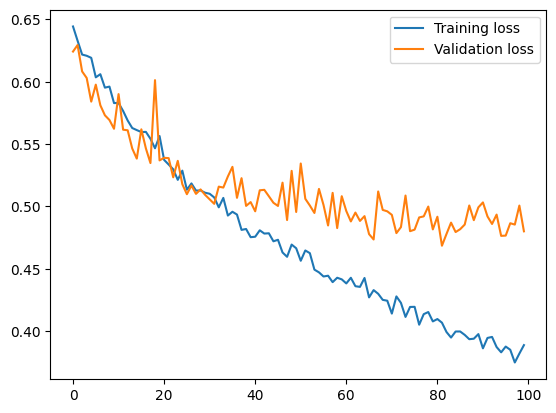

In [99]:
plt.plot(np.array(train_losses), label='Training loss')
plt.plot(np.array(val_losses), label='Validation loss')
plt.legend()
plt.show()

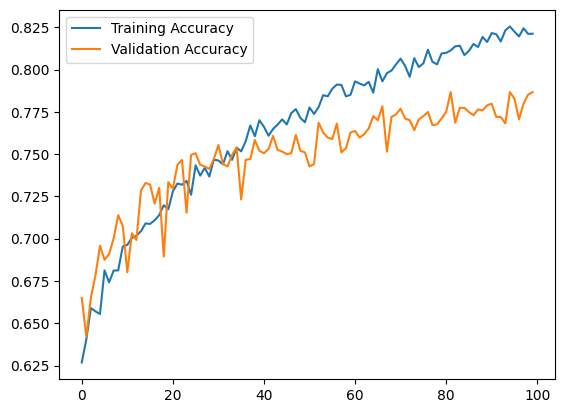

In [100]:
plt.plot(np.array(train_accuracy), label='Training Accuracy')
plt.plot(np.array(val_accuracy), label='Validation Accuracy')
plt.legend()
plt.show()

In the following, we will evaluate the last epoch on the test dataset and calculate the accuracy, look at some outputs and the confusion matrix.

In [101]:
# predicting labels for test data and calculating accuracy
correct = 0
total = 0
test_preds = []
test_labels = []
test_images = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        test_preds.append(predicted.cpu())
        test_labels.append(labels.cpu())
        test_images.append(images.cpu())
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
    test_preds = torch.cat(test_preds).numpy()
    test_labels = torch.cat(test_labels).numpy()
    test_images = torch.cat(test_images)

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 2000 test images: 78 %


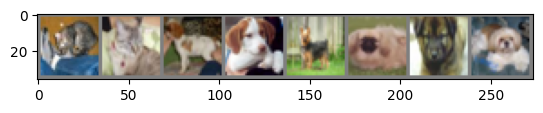

Truth:      cat   cat   dog   dog   dog   dog   dog   dog  
Predicted:  cat   cat   dog   dog   dog   dog   dog   dog  


In [102]:
images_to_plot = 8

# show images
imshow(torchvision.utils.make_grid(test_images[:images_to_plot]))
# print labels
print('Truth:     ', ' '.join(f'{classes[test_labels[j]]:5s}' for j in range(images_to_plot)))
print('Predicted: ', ' '.join(f'{classes[test_preds[j]]:5s}' for j in range(images_to_plot)))

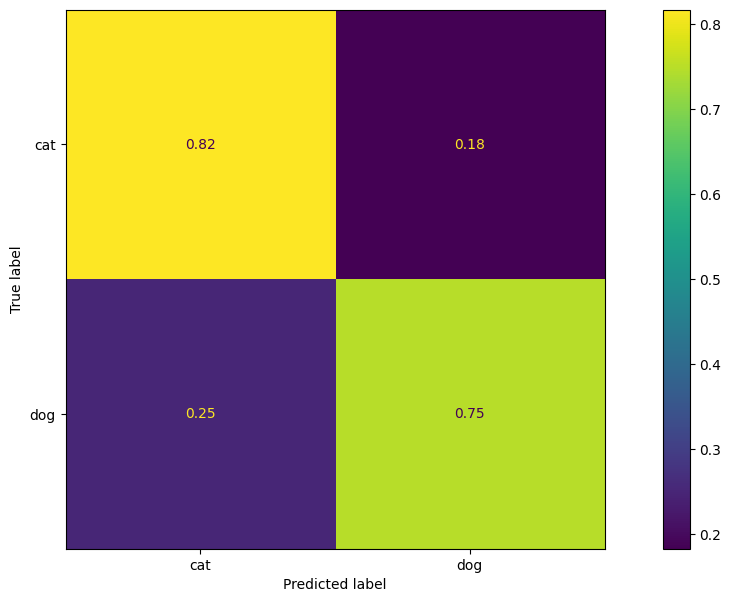

In [103]:
# Create confusion matrix and normalizes it over true labels
confusion = confusion_matrix(test_labels, test_preds, normalize='true')

# Create a plot of the confusion matrix
fig, ax = plt.subplots(figsize=(15, 7))
ConfusionMatrixDisplay(confusion, display_labels=classes).plot(ax=ax)
plt.show()

# Task

**Create a CNN that achieves a validation accuracy of at least 70%**

- Feel free to experiment on the network structure yourself. Use a combination of convolutional and pooling layers, similar to the first exercise.
- If your train and validation metrics diverge, you should consider including [Dropout layers](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

# Bonus tasks

- A network with many parameters may perform better but a small network is trained faster and requires less computing resources. Can you reach the 70% validation accuracy in less than 20 epochs?
- The dataset does not only contain Cat and Dog pictures but 10 classes in total. You could rebuild the model as a multi-classifier. To achieve this, you would need to:
    - Include additional classes in your input. Do this by commenting out the one line of code in the data loading section.
    - What else do you need to change to make the model a multi-classifier?
    - Try to achieve the best validation accuracy you can. Which other parameters besides the architecture can you change to affect the performance?
- Implement a ResNet and apply it to the dataset. For example, you can add another class inheriting from `nn.Module` that implements a single reset block, including two convolutions, activation function and the skip connection.